In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time
import sys
import math
import datetime
from math import radians, cos, sin, asin, sqrt
from matplotlib.colors import LogNorm
from io import StringIO
from sklearn import linear_model
#import tensorflow as tf
plt.rcParams["font.sans-serif"]=["SimHei"] #用来正常显示中文标签
plt.rcParams["axes.unicode_minus"]=False #用来正常显示负号

In [2]:
import re                                               
def go_split(s, symbol):
    # 拼接正则表达式
    symbol = "[" + symbol + "]+"
    # 一次性分割字符串
    result = re.split(symbol, s)
    # 去除空字符
    return [x for x in result if x]

In [3]:
cen_x=[121.492494]   #城市中心坐标
cen_y=[31.225719]

In [4]:
class Ant(object):
    # 初始化
    def __init__(self,ID,distance_graph,pheromone_graph,ALPHA,BETA):
        self.city_num=len(distance_graph)
        self.distance_graph=distance_graph #距离矩阵
        self.pheromone_graph=pheromone_graph #信息素矩阵
        self.ID = ID  # ID
        (self.ALPHA, self.BETA) = (ALPHA , BETA)#蚂蚁在选择路径时  信息素与距离反比的比重
        self.path = []  # 当前蚂蚁的路径
        self.total_distance = 0.0  # 当前路径的总距离
        self.move_count = 0  # 移动次数
        self.current_city = -1  # 当前停留的城市
        self.open_table_city = [True for i in range(self.city_num)]  # 探索城市的状态
        if self.city_num >2:  #如果商店数目大于2那么就不能走city[1]
            self.open_table_city[1]=False
        #city_index = random.randint(0, self.city_num - 1)  # 随机初始出生点
        city_index=0 #初始点是开始点
        self.current_city = city_index
        self.path.append(city_index)  # 这只蚂蚁经过的路径
        self.open_table_city[city_index] = False  # 城市是否无访问
        self.move_count = 1
 
    # 选择下一个城市
    def _choice_next_city(self):

        next_city = -1
        select_citys_prob = [0.0 for i in range(self.city_num)]  #选择城市的可能性
        total_prob = 0.0

        # 获取去下一个城市的概率
        for i in range(self.city_num):
            if self.open_table_city[i]:
                try:
                    # 计算概率：与信息素浓度成正比，与距离成反比
                    select_citys_prob[i] = pow(self.pheromone_graph[self.current_city][i], self.ALPHA) * pow(
                        (1.0 / (self.distance_graph[self.current_city][i]+0.00001)), self.BETA)
                    total_prob += select_citys_prob[i]
                except ZeroDivisionError as e:
                    print('Ant ID: {ID}, current city: {current}, target city: {target}'.format(ID=self.ID,current=self.current_city,target=i))
                    sys.exit(1)

        # 轮盘选择城市
        if total_prob > 0.0:
            # 产生一个随机概率
            temp_prob = random.uniform(0.0, total_prob)
            for i in range(self.city_num):
                if self.open_table_city[i]:#如果城市没有被访问
                    # 轮次相减
                    temp_prob -= select_citys_prob[i]
                    if temp_prob < 0.0:
                        next_city = i
                        break

        # 未从概率产生，顺序选择一个未访问城市 如果temp_prob恰好选择了total_prob那么就在所有未去的城市中选择一个去的城市
        if next_city == -1:
            for i in range(self.city_num):
                if self.open_table_city[i]:
                    next_city = i
                    break

        # 返回下一个城市序号
        return next_city

    # 移动操作
    def _move(self, next_city):
        self.path.append(next_city)
        self.open_table_city[next_city] = False
        self.current_city = next_city
        self.move_count += 1

    #翻转操作
    def _reverse(self,start,end):#表示是protect函数
        #self.path[start:end+1]=self.path[end:start-1:-1]   #从bc  变成cb
        tmpPath=self.path.copy()
        tmpPath[start:end+1]=tmpPath[end:start-1:-1]
        return tmpPath

    def _cal_lenth(self,path):
        temp_distance = 0.0
        for i in range(1, len(path)):
            start, end = path[i], path[i - 1]
            temp_distance += self.distance_graph[start][end]
        return temp_distance

    def _need_reverse(self,start,end):
        tmpPath=self.path[start-1:end+2].copy()
        tmpPath[1:-1]=tmpPath[-2:0:-1]
        return self._cal_lenth(tmpPath) < self._cal_lenth(self.path[start-1:end+2])

    # 搜索路径
    def search_path(self):
        # 搜素路径，遍历完所有城市为止
        while self.move_count < self.city_num:
            # 移动到下一个城市
            next_city = self._choice_next_city()
            self._move(next_city)
            if self.move_count== self.city_num-1:#最后一个城市选择终点城市
                self.open_table_city[1]=True

        # 计算路径总长度
        self.total_distance=self._cal_lenth(self.path)

        i=2#步长
        while i < self.city_num-1:
            j=1#起始位置
            while j < self.city_num-i:
                if self._need_reverse(j,i+j-1):
                    self.path=self._reverse(j,i+j-1) #得到翻转之后的路径
                    self.total_distance =self._cal_lenth(self.path)  #更新总长度
                    i=2#重做整个结果
                    j=1
                j+=1
            i+=1



class tsp(object):

    def __init__(self,data_set):#data_set是所有点的经纬度坐标，label_list是这个分组的编号序列
        self.cities = data_set  # 商店的地址（经纬度信息）
        self.maxIter = 1 #蚁群算法的最大迭代次数
        self.rootNum = data_set.shape[0]#本分组的商店的数目
        (self.city_num, self.ant_num) = (self.rootNum, 30)
        (self.ALPHA, self.BETA, self.RHO, self.Q) = (1.0, 9.0, 0.5, 100.0)#蚁群算法参数
        self.distance_graph=[[0.0 for i in range(self.city_num)] for j in range(self.city_num)]
        self.pheromone_graph=[[1.0 for i in range(self.city_num)] for j in range(self.city_num)]
        self.get_Dis_Pherom()#初始化距离
        self.new()



    def transf_Dist(self,lon1, lat1, lon2, lat2):  # 经度1，纬度1，经度2，纬度2 （十进制度数）
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)
        """
        # 将十进制度数转化为弧度
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        # haversine公式
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * asin(sqrt(a))
        r = 6371  # 地球平均半径，单位为公里
        return c * r * 1000


    def get_Dis_Pherom(self):
        # 初始化城市距离
        for i in range(self.city_num):
            for j in range(self.city_num):
                self.distance_graph[i][j] =self.transf_Dist(self.cities[i,0],self.cities[i,1],self.cities[j,0],self.cities[j,1])

    def new(self,evt=None):
        # 初始化信息素
        self.ants = [Ant(ID,self.distance_graph,self.pheromone_graph,self.ALPHA, self.BETA) for ID in range(self.ant_num)]  # 初始蚁群
        self.best_ant = self.ants[-1]  # 初始最优解
        self.best_ant.total_distance = (1 << 31)  # 初始最大距离
        self.iter = 0  # 初始化迭代次数


    def search_path(self,evt=None):
        while self.iter<self.maxIter:
            # 遍历每一只蚂蚁
            for ant in self.ants:
                # 搜索一条路径
                ant.search_path()
                # 与当前最优蚂蚁比较
                if ant.total_distance < self.best_ant.total_distance:
                    # 更新最优解
                    self.best_ant = copy.deepcopy(ant)
            # 更新信息素
            self.update_pheromone_gragh()
            #print("迭代次数：", self.iter, u"最佳路径总距离：", int(self.best_ant.total_distance))
            #self.draw()
            self.iter += 1
        #self.draw()
        return self.best_ant.path


    def update_pheromone_gragh(self):
        # 获取每只蚂蚁在其路径上留下的信息素
        temp_pheromone = [[0.0 for col in range(self.city_num)] for raw in range(self.city_num)]
        for ant in self.ants:
            for i in range(1, self.city_num):
                start, end = ant.path[i - 1], ant.path[i]
                # 在路径上的每两个相邻城市间留下信息素，与路径总距离反比
                temp_pheromone[start][end] += self.Q / ant.total_distance
                temp_pheromone[end][start] = temp_pheromone[start][end]

        # 更新所有城市之间的信息素，旧信息素衰减加上新迭代信息素
        for i in range(self.city_num):
            for j in range(self.city_num):
                self.pheromone_graph[i][j] = self.pheromone_graph[i][j] * self.RHO + temp_pheromone[i][j]


def draw_line(cities,bestPath):
    city_num=cities.shape[0]
    ax = plt.subplot(111)
    ax.plot(cities[:, 0], cities[:, 1], 'x', color='blue')
    ax.plot(cities[0,0],cities[0,1],'ro')
    ax.plot(cities[1, 0], cities[1, 1], 'ro')
    for i in range(city_num):
        ax.text(cities[i, 0], cities[i, 1], str(i))
    ax.plot(cities[bestPath, 0], cities[bestPath, 1], color='red')
    plt.show()

def notInList(lon,lat,pointList):
    for i in range(0,len(pointList)):
        if abs(lon-pointList[i][0])<=0.000001 and abs(lat-pointList[i][1])<=0.000001:
            return i
    return len(pointList)

def get_route(startlon,startlat,endlon,endlat,pointdarry):
    pointList=pointdarry.tolist()
    listLen=len(pointList)
    sameIndex=notInList(startlon,startlat,pointList)
    if sameIndex < listLen:
        pointList.pop(sameIndex)
    sameIndex = notInList(endlon, endlat, pointList)
    listLen=len(pointList)
    if sameIndex < listLen:
        pointList.pop(sameIndex)
    coordinateList=[[startlon,startlat],[endlon, endlat]]
    coordinateList+=pointList
    dataSet=np.array(coordinateList)
    pathList = tsp(dataSet).search_path()
    #draw_line(dataSet, pathList)
    resultList=[]
    for i in range(len(pathList)):
        if i>0 :
            if coordinateList[pathList[i]][0]==coordinateList[pathList[i-1]][0] and coordinateList[pathList[i]][1]==coordinateList[pathList[i-1]][1]:
                continue
            else :
                resultList.append(coordinateList[pathList[i]])
        else :
            resultList.append(coordinateList[pathList[i]])
    return resultList


In [5]:
col = ['darkgoldenrod','darkgray', 'darkgreen','darkkhaki','darkmagenta','darkorange','darkorchid','darkred','darksalmon','orange','lightgreen', 'lightgray','lightpink','lightsalmon','lightseagreen','lightskyblue','lightslategray','lightsteelblue','lightyellow', 
'lime','cornflowerblue','cornsilk','crimson','cyan', 'darkblue','darkcyan','aliceblue','antiquewhite','aqua','aquamarine','azure','beige','bisque','black','blanchedalmond','blue','blueviolet','brown', 
'burlywood', 'cadetblue','chartreuse','chocolate', 'coral', 'darkolivegreen', 'darkseagreen',
'darkslateblue', 'darkslategray','darkturquoise','darkviolet', 'deeppink','deepskyblue','dimgray','dodgerblue', 'firebrick','floralwhite', 
'forestgreen', 'fuchsia','gainsboro', 'ghostwhite','gold','goldenrod','gray','green', 'greenyellow', 'honeydew','hotpink','indianred', 
'indigo', 'ivory','khaki','lavender','lavenderblush','lawngreen','lemonchiffon','lightblue','lightcoral', 'lightcyan', 'lightgoldenrodyellow', 
'lightgreen', 'lightgray','lightpink','lightsalmon','lightseagreen','lightskyblue','lightslategray','lightsteelblue','lightyellow', 
'lime', 'limegreen','linen','magenta', 'maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen', 
'mediumslateblue', 'mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue', 'mintcream','mistyrose','moccasin', 
'navajowhite', 'navy','oldlace','olive','olivedrab','orangered','orchid','palegoldenrod','palegreen','paleturquoise', 
'palevioletred','papayawhip','peachpuff','peru','pink','plum','powderblue','purple','red','rosybrown','royalblue','saddlebrown','salmon', 
'sandybrown', 'seagreen','seashell', 'sienna','silver','skyblue','slateblue','slategray','snow','springgreen','steelblue','tan','teal', 
'thistle', 'tomato','turquoise','violet', 'wheat', 'white','whitesmoke','yellow', 'yellowgreen'] 

In [6]:
pr=list(np.load("边界坐标.npy"))              #读取边界坐标
asr=list(np.load("边界坐标（1）.npy"))
br=list(np.load("边界坐标（2）.npy"))
h5=list(np.load("边界坐标（3）.npy"))
c=list(np.load("边界坐标（4）.npy"))
h2=list(np.load("边界坐标（5）.npy"))

In [7]:
pr1=[]                            #边界经纬度坐标
pr2=[]
for i in range(0,len(pr)):
    l=pr[i][1]
    pr1.append(l)
    m=pr[i][0]
    pr2.append(m)

aa1=[]
aa2=[]
for i in range(0,len(asr)):
    r=asr[i][0]
    r1=asr[i][1]
    aa1.append(r)
    aa2.append(r1)
    
b1=[]
b2=[]
for i in range(0,len(br)):
    r=br[i][0]
    r1=br[i][1]
    b1.append(r)
    b2.append(r1)
    
h3=[]
h4=[]
for i in range(0,len(h5)):
    r=h5[i][0]
    r1=h5[i][1]
    h3.append(r)
    h4.append(r1)
    
c1=[]
c2=[]
for i in range(0,len(c)):
    r=c[i][1]
    r1=c[i][0]
    c1.append(r)
    c2.append(r1)
    
h=[]
h1=[]
r=h2[0][0]
h.append(r)
r1=h2[1][0]
h.append(r1)

r3=h2[0][1]
h1.append(r3)
r4=h2[1][1]
h1.append(r4)

In [8]:
daf1=np.load("df8_1.npy",allow_pickle=True)    #根据原数据得到的包含最短路径的数据(去燥后综合13)
df1=pd.DataFrame(daf1,columns=["orderid","bikeid","userid","start_time","start_location_x","start_location_y","end_time","end_location_x","end_location_y","track","l","d","t","speed","scoup1","ecoup1","se","es"])
df1

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track,l,d,t,speed,scoup1,ecoup1,se,es
0,1,324731,7541,2016-08-28 00:00,121.49,31.28,2016-08-28 00:08,121.486,31.273,"121.485,31.275#121.485,31.276#121.486,31.273#1...",14,1.3,8,0.16,"[-1, 13]","[-2, 11]","[-1, 13, -2, 11]","[-2, 11, -1, 13]"
1,6,288841,4427,2016-08-28 00:00,121.462,31.313,2016-08-28 00:17,121.455,31.315,"121.455,31.313#121.455,31.314#121.455,31.315#1...",10,0.9,17,0.05,"[-6, 20]","[-8, 20]","[-6, 20, -8, 20]","[-8, 20, -6, 20]"
2,8,315873,6474,2016-08-28 00:00,121.416,31.154,2016-08-28 00:14,121.419,31.156,"121.416,31.154#121.416,31.155#121.417,31.155#1...",11,1.2,14,0.09,"[-15, -16]","[-14, -16]","[-15, -16, -14, -16]","[-14, -16, -15, -16]"
3,10,93155,12616,2016-08-28 00:00,121.436,31.32,2016-08-28 00:12,121.444,31.31,"121.436,31.318#121.436,31.319#121.436,31.320#1...",17,1.8,12,0.15,"[-11, 21]","[-10, 19]","[-11, 21, -10, 19]","[-10, 19, -11, 21]"
4,11,352484,11596,2016-08-28 00:00,121.459,31.325,2016-08-28 00:08,121.46,31.315,"121.459,31.315#121.459,31.316#121.459,31.317#1...",12,1.2,8,0.15,"[-7, 23]","[-7, 20]","[-7, 23, -7, 20]","[-7, 20, -7, 23]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022090,1800966,95386,12020,2016-08-26 21:39,121.498,31.377,2016-08-26 23:31,121.43,31.24,"121.428,31.243#121.428,31.244#121.429,31.240#1...",260,27.9,112,0.25,"[2, 34]","[-12, 4]","[2, 34, -12, 4]","[-12, 4, 2, 34]"
1022091,1802991,220251,16776,2016-08-26 22:06,121.455,31.19,2016-08-27 00:07,121.402,31.28,"121.402,31.280#121.403,31.279#121.403,31.280#1...",231,24.3,121,0.2,"[-8, -8]","[-18, 13]","[-8, -8, -18, 13]","[-18, 13, -8, -8]"
1022092,1803981,321243,8131,2016-08-26 22:21,121.434,31.235,2016-08-27 00:52,121.437,31.236,"121.431,31.235#121.431,31.236#121.432,31.234#1...",229,26.2,151,0.17,"[-12, 3]","[-11, 3]","[-12, 3, -11, 3]","[-11, 3, -12, 3]"
1022093,1806508,7642,15851,2016-08-26 23:13,121.365,31.178,2016-08-27 00:03,121.461,31.217,"121.364,31.179#121.364,31.180#121.365,31.178#1...",207,26.4,50,0.53,"[-25, -11]","[-6, -2]","[-25, -11, -6, -2]","[-6, -2, -25, -11]"


In [9]:
user_outnum=df1["userid"].value_counts()     #查看每个userid的数量（出行次数）
#user_outnum

In [10]:
userid=(user_outnum.index).tolist()   #用户id
user_outn=(user_outnum.values).tolist()  #用户出行次数
df4_1=pd.DataFrame(userid,columns=["userid"])
df5_1=pd.DataFrame(user_outn,columns=["user_outn"])
df6=pd.concat([df4_1,df5_1],axis=1,join="inner")        #用户id-出行次数

In [11]:
df6_1=df6[0:10]    #出行最活跃的前10个用户  即出行次数前10的用户

In [12]:
x12=[121.27,121.27]
y12=[31.36,31.09]
x13=[121.275,121.575]
y13=[31.36,31.36]
x34=[121.575,121.575]
y34=[31.36,31.09]
x42=[121.575,121.275]
y42=[31.09,31.09]

In [13]:
xx1=[121.7,122.0]
yy1=[30.7,30.7]
xx2=[121.7,121.7]
yy2=[30.68,30.72]
xx3=[122.0,122.0]

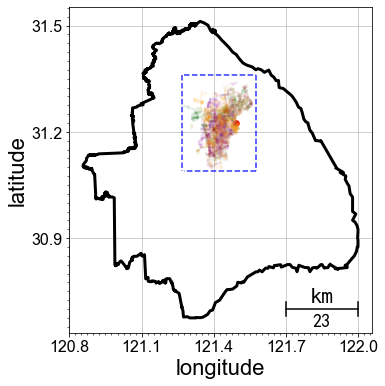

In [15]:
fig= plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1) 
fig.set_facecolor('white')
plt.plot(aa1,aa2,color="black",linewidth="3")
plt.plot(b1,b2,color="black",linewidth="3")
plt.plot(c1,c2,color="black",linewidth="3")
plt.plot(pr1,pr2,color="black",linewidth="3")
plt.plot(h,h1,color="black",linewidth="3")
plt.plot(h3,h4,color="black",linewidth="3")
#plt.legend(loc="best")
#ax.set_xlim(120.8,122.1)
#ax.set_ylim(30.5,31.5)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))#设置x主坐标间隔 1       
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.025))#设置x从坐标间隔 0.1    经度相差1度  距离随纬度变化
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))#设置y主坐标间隔 1
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.025))#设置y从坐标间隔 0.1    纬度相差1度是111公里
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75')#由每个x主坐标出发对x主坐标画垂直于x轴的线段
#ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75')#由每个x主坐标出发对x主坐标画垂直于x轴的线段
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
#ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
#plt.title("All starting points",fontsize=18)    #所有出发点
ax.set_xlabel("longitude",fontdict={'size'   : 22,"family":"Arial"})#经度
ax.set_ylabel("latitude",fontdict={ 'size'   : 22,"family":"Arial"})#纬度
my_x_ticks = np.arange(120.8, 122.2, 0.3)
plt.xticks(my_x_ticks)
my_y_ticks = np.arange(30.6,31.8, 0.3)
plt.yticks(my_y_ticks)
plt.yticks(fontproperties = 'Arial')
plt.xticks(fontproperties = 'Arial')
plt.tick_params(labelsize=16)
#plt.savefig("picture1.pdf")
for i in range(0,len(df6_1)):      #遍历每个用户
    uid=df6_1.iloc[i]["userid"]
    dfrl=df1[df1["userid"]==uid]    #查询每个用户的出行记录
    #h=random.randrange(139)
    colo=col[i]
    #print(colo)
    for index,row in dfrl.iterrows():                                             #遍历某个用户所有的路径
        symbol = '#'
        s=row["track"]
        dd1=row["start_location_x"]
        dd2=row["start_location_y"]
        dd3=row["end_location_x"]
        dd4=row["end_location_y"]
        r_1=go_split(s, symbol)
        frame1=pd.DataFrame(r_1,columns=["location"])
        frame1["location_x"]=frame1["location"].map(lambda x:x.split(",")[0])
        frame1["location_y"]=frame1["location"].map(lambda x:x.split(",")[1])
        frame2=frame1[["location_x","location_y"]]
        for index in range(0,len(frame2)):                             #将坐标dtype转换为float
            frame2.loc[index]["location_x"]=float(frame2.loc[index]["location_x"])
            frame2.loc[index]["location_y"]=float(frame2.loc[index]["location_y"])
        frame2=np.array(frame2)
    
        if __name__ == '__main__':
            point_num = len(frame2)  # 点的数目
            random.seed(point_num)
            data_set = frame2# 生成point_num个随机的经纬坐标信息
        #其中第0个点是起点，第1个点是终点
        
            resultList=get_route(dd1, dd2, dd3, dd4,data_set)
            #print(resultList)
            
            m=[]
            n=[]
            for i in range(0,len(resultList)):
                m.append(resultList[i][0])
                n.append(resultList[i][1])
            plt.plot(m,n,alpha=0.09,color=colo,linewidth=2)
ax.scatter(cen_x,cen_y,color="red",s=30)
plt.plot(x12,y12,color='blue',alpha=0.8,ls='--')
plt.plot(x13,y13,color='blue',alpha=0.8,ls='--')
plt.plot(x34,y34,color='blue',alpha=0.8,ls='--')
plt.plot(x42,y42,color='blue',alpha=0.8,ls='--')
plt.plot(xx1,yy1,color='black')
plt.plot(xx2,yy2,color='black')
plt.plot(xx3,yy2,color='black')
plt.text(121.80,30.72, 'km',fontdict=dict(fontsize=20,family='monospace'))
plt.text(121.81,30.65, '23',fontsize=18)
fig.subplots_adjust(left=0.2)
#plt.savefig('sh用户.pdf')
plt.savefig('sh用户.pdf',bbox_inches='tight')

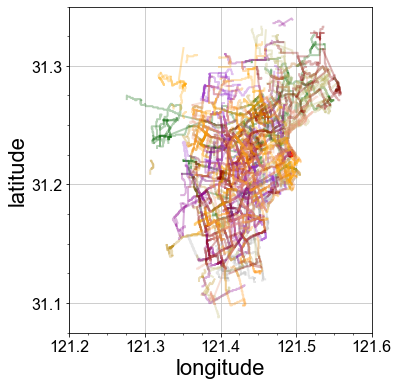

In [16]:
fig= plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1) 
fig.set_facecolor('white')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))#设置x主坐标间隔 1       
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.025))#设置x从坐标间隔 0.1    经度相差1度  距离随纬度变化
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))#设置y主坐标间隔 1
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.025))#设置y从坐标间隔 0.1    纬度相差1度是111公里
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75')#由每个x主坐标出发对x主坐标画垂直于x轴的线段
#ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75')#由每个x主坐标出发对x主坐标画垂直于x轴的线段
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
#ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
#plt.title("All starting points",fontsize=18)    #所有出发点
ax.set_xlabel("longitude",fontdict={'size'   : 22,"family":"Arial"})#经度
ax.set_ylabel("latitude",fontdict={ 'size'   : 22,"family":"Arial"})#纬度
#my_x_ticks = np.arange(120.8, 122.2, 0.2)
#plt.xticks(my_x_ticks)
#my_y_ticks = np.arange(30.6,31.8, 0.2)
#plt.yticks(my_y_ticks)
ax.set_xlim(121.2,121.6)
ax.set_ylim(31.075,31.35)
plt.yticks(fontproperties = 'Arial')
plt.xticks(fontproperties = 'Arial')
plt.tick_params(labelsize=16)
for i in range(0,len(df6_1)):      #遍历每个用户
    uid=df6_1.iloc[i]["userid"]
    dfrl=df1[df1["userid"]==uid]    #查询每个用户的出行记录
    #h=random.randrange(139)
    colo=col[i]
    #print(colo)
    for index,row in dfrl.iterrows():                                             #遍历某个用户所有的路径
        symbol = '#'
        s=row["track"]
        dd1=row["start_location_x"]
        dd2=row["start_location_y"]
        dd3=row["end_location_x"]
        dd4=row["end_location_y"]
        r_1=go_split(s, symbol)
        frame1=pd.DataFrame(r_1,columns=["location"])
        frame1["location_x"]=frame1["location"].map(lambda x:x.split(",")[0])
        frame1["location_y"]=frame1["location"].map(lambda x:x.split(",")[1])
        frame2=frame1[["location_x","location_y"]]
        for index in range(0,len(frame2)):                             #将坐标dtype转换为float
            frame2.loc[index]["location_x"]=float(frame2.loc[index]["location_x"])
            frame2.loc[index]["location_y"]=float(frame2.loc[index]["location_y"])
        frame2=np.array(frame2)
    
        if __name__ == '__main__':
            point_num = len(frame2)  # 点的数目
            random.seed(point_num)
            data_set = frame2# 生成point_num个随机的经纬坐标信息
        #其中第0个点是起点，第1个点是终点
        
            resultList=get_route(dd1, dd2, dd3, dd4,data_set)
            #print(resultList)
            
            m=[]
            n=[]
            for i in range(0,len(resultList)):
                m.append(resultList[i][0])
                n.append(resultList[i][1])
            plt.plot(m,n,alpha=0.3,color=colo,linewidth=2)
#plt.legend(loc="best")
ax.scatter(cen_x,cen_y,color="red",s=30)
fig.subplots_adjust(left=0.2)
plt.savefig('sh用户（1）.pdf',bbox_inches='tight')


In [17]:
bike_outnum=df1["bikeid"].value_counts()     #查看每个车的数量（出行次数）
#bike_outnum

In [18]:
bikeid=(bike_outnum.index).tolist()   #车id
bike_outn=(bike_outnum.values).tolist()  #车出行次数
dfr4_1=pd.DataFrame(bikeid,columns=["bikeid"])
dfr5_1=pd.DataFrame(bike_outn,columns=["bike_outn"])
dfr6=pd.concat([dfr4_1,dfr5_1],axis=1,join="inner")        #车id-出行次数

In [19]:
dfr6_1=dfr6[0:10]

In [20]:
x12=[121.3,121.3]
y12=[31.425,31.1]
x13=[121.3,121.575]
y13=[31.425,31.425]
x34=[121.575,121.575]
y34=[31.425,31.1]
x42=[121.575,121.3]
y42=[31.1,31.1]

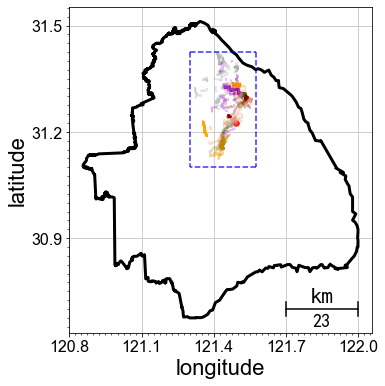

In [22]:
fig= plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1) 
fig.set_facecolor('white')
plt.plot(aa1,aa2,color="black",linewidth="3")
plt.plot(b1,b2,color="black",linewidth="3")
plt.plot(c1,c2,color="black",linewidth="3")
plt.plot(pr1,pr2,color="black",linewidth="3")
plt.plot(h,h1,color="black",linewidth="3")
plt.plot(h3,h4,color="black",linewidth="3")
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))#设置x主坐标间隔 1       
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.025))#设置x从坐标间隔 0.1    经度相差1度  距离随纬度变化
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))#设置y主坐标间隔 1
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.025))#设置y从坐标间隔 0.1    纬度相差1度是111公里
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75')#由每个x主坐标出发对x主坐标画垂直于x轴的线段
#ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75')#由每个x主坐标出发对x主坐标画垂直于x轴的线段
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
#ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
#plt.title("All starting points",fontsize=18)    #所有出发点
ax.set_xlabel("longitude",fontdict={'size'   : 22,"family":"Arial"})#经度
ax.set_ylabel("latitude",fontdict={ 'size'   : 22,"family":"Arial"})#纬度
my_x_ticks = np.arange(120.8, 122.2, 0.3)
plt.xticks(my_x_ticks)
my_y_ticks = np.arange(30.6,31.8, 0.3)
plt.yticks(my_y_ticks)
plt.yticks(fontproperties = 'Arial')
plt.xticks(fontproperties = 'Arial')
plt.tick_params(labelsize=16)
for i in range(0,len(dfr6_1)):      #遍历每个车
    bid=dfr6_1.iloc[i]["bikeid"]
    dfrl=df1[df1["bikeid"]==bid]    #查询每个车的出行记录
    #h=random.randrange(139)
    colo=col[i]
    #print(colo)
    for index,row in dfrl.iterrows():                                             #遍历某个车所有的路径
        symbol = '#'
        s=row["track"]
        dd1=row["start_location_x"]
        dd2=row["start_location_y"]
        dd3=row["end_location_x"]
        dd4=row["end_location_y"]
        r_1=go_split(s, symbol)
        frame1=pd.DataFrame(r_1,columns=["location"])
        frame1["location_x"]=frame1["location"].map(lambda x:x.split(",")[0])
        frame1["location_y"]=frame1["location"].map(lambda x:x.split(",")[1])
        frame2=frame1[["location_x","location_y"]]
        for index in range(0,len(frame2)):                             #将坐标dtype转换为float
            frame2.loc[index]["location_x"]=float(frame2.loc[index]["location_x"])
            frame2.loc[index]["location_y"]=float(frame2.loc[index]["location_y"])
        frame2=np.array(frame2)
    
        if __name__ == '__main__':
            point_num = len(frame2)  # 点的数目
            random.seed(point_num)
            data_set = frame2# 生成point_num个随机的经纬坐标信息
        #其中第0个点是起点，第1个点是终点
        
            resultList=get_route(dd1, dd2, dd3, dd4,data_set)
            #print(resultList)
            
            m=[]
            n=[]
            for i in range(0,len(resultList)):
                m.append(resultList[i][0])
                n.append(resultList[i][1])
            plt.plot(m,n,alpha=0.3,color=colo,linewidth=2)
ax.scatter(cen_x,cen_y,color="red",s=30)
plt.plot(x12,y12,color='blue',alpha=0.8,ls='--')
plt.plot(x13,y13,color='blue',alpha=0.8,ls='--')
plt.plot(x34,y34,color='blue',alpha=0.8,ls='--')
plt.plot(x42,y42,color='blue',alpha=0.8,ls='--')
plt.plot(xx1,yy1,color='black')
plt.plot(xx2,yy2,color='black')
plt.plot(xx3,yy2,color='black')
plt.text(121.80,30.72, 'km',fontdict=dict(fontsize=20,family='monospace'))
plt.text(121.81,30.65, '23',fontsize=18)
fig.subplots_adjust(left=0.2)
plt.savefig('sh单车.pdf',bbox_inches='tight')

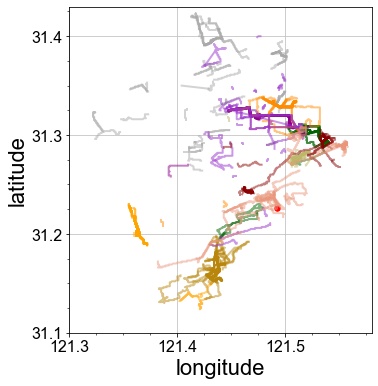

In [23]:
fig= plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1) 
fig.set_facecolor('white')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))#设置x主坐标间隔 1       
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.025))#设置x从坐标间隔 0.1    经度相差1度  距离随纬度变化
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))#设置y主坐标间隔 1
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.025))#设置y从坐标间隔 0.1    纬度相差1度是111公里
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75')#由每个x主坐标出发对x主坐标画垂直于x轴的线段
#ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75')#由每个x主坐标出发对x主坐标画垂直于x轴的线段
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
#ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
#plt.title("All starting points",fontsize=18)    #所有出发点
ax.set_xlabel("longitude",fontdict={'size'   : 22,"family":"Arial"})#经度
ax.set_ylabel("latitude",fontdict={ 'size'   : 22,"family":"Arial"})#纬度
#my_x_ticks = np.arange(120.8, 122.2, 0.2)
#plt.xticks(my_x_ticks)
#my_y_ticks = np.arange(30.6,31.8, 0.2)
#plt.yticks(my_y_ticks)
ax.set_xlim(121.3,121.58)
ax.set_ylim(31.1,31.43)
plt.yticks(fontproperties = 'Arial')
plt.xticks(fontproperties = 'Arial')
plt.tick_params(labelsize=16)
for i in range(0,len(dfr6_1)):      #遍历每个车
    bid=dfr6_1.iloc[i]["bikeid"]
    dfrl=df1[df1["bikeid"]==bid]    #查询每个车的出行记录
    #h=random.randrange(139)
    colo=col[i]
    #print(colo)
    for index,row in dfrl.iterrows():                                             #遍历某个车所有的路径
        symbol = '#'
        s=row["track"]
        dd1=row["start_location_x"]
        dd2=row["start_location_y"]
        dd3=row["end_location_x"]
        dd4=row["end_location_y"]
        r_1=go_split(s, symbol)
        frame1=pd.DataFrame(r_1,columns=["location"])
        frame1["location_x"]=frame1["location"].map(lambda x:x.split(",")[0])
        frame1["location_y"]=frame1["location"].map(lambda x:x.split(",")[1])
        frame2=frame1[["location_x","location_y"]]
        for index in range(0,len(frame2)):                             #将坐标dtype转换为float
            frame2.loc[index]["location_x"]=float(frame2.loc[index]["location_x"])
            frame2.loc[index]["location_y"]=float(frame2.loc[index]["location_y"])
        frame2=np.array(frame2)
    
        if __name__ == '__main__':
            point_num = len(frame2)  # 点的数目
            random.seed(point_num)
            data_set = frame2# 生成point_num个随机的经纬坐标信息
        #其中第0个点是起点，第1个点是终点
        
            resultList=get_route(dd1, dd2, dd3, dd4,data_set)
            #print(resultList)
            
            m=[]
            n=[]
            for i in range(0,len(resultList)):
                m.append(resultList[i][0])
                n.append(resultList[i][1])
            plt.plot(m,n,alpha=0.5,color=colo,linewidth=2)
#plt.legend(loc="best")
ax.scatter(cen_x,cen_y,color="red",s=30)
fig.subplots_adjust(left=0.2)
plt.savefig('sh单车（1）.pdf',bbox_inches='tight')